In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

In [ ]:
#importing dataset
dataset_directory = os.listdir('/content/drive/MyDrive/Plant_Village_data/PotatoLeafImage_data')
for filenames in dataset_directory:
    print(filenames)

Potato___Late_blight
Potato___healthy
Potato___Early_blight


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import cv2

In [ ]:
#Global initialization of some imp variables
Image_Size = 256
Batch_Size = 48
Channels = 3

In [ ]:
dataset_directory = '/content/drive/MyDrive/Plant_Village_data/PotatoLeafImage_data'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,  # this should be a string, not a list
    batch_size=Batch_Size,
    image_size=(Image_Size, Image_Size),
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [ ]:
#Folders(classes) in 'Dataset' directory
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset) # Number of Batches = (total number of files belonging to all classes / Batch_Size)

45

In [ ]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)

    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_data, val_data, test_data = split_dataset(dataset)

In [ ]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_data), len(val_data), len(test_data)))

Size of Data is :45 
Batch size of Training Data is :36
Batch size of Validation Data is :4 
Batch size of Testing Data is :5 


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# Image Preprocessing : Rescaling and Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
# Define the data augmentation in a Sequential model
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest'),
  layers.experimental.preprocessing.RandomContrast(factor=0.2)
])


In [ ]:
train_ds = train_data.cache().shuffle(1000).map(
  lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [ ]:
# Model at Batch Size 48 and Learning Rate 0.001
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model_48_DR4_001 = Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')
])
model_48_DR4_001.build(input_shape = input_shape)
model_48_DR4_001.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (48, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (48, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (48, 127, 127, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (48, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (48, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (48, 60, 60, 64)         

In [ ]:
learning_rate = 0.001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_48_DR4_001.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [ ]:
#Fit the model with training data and also pass validation data
history_48_DR4_001 = model_48_DR4_001.fit(
train_ds, epochs = 200, batch_size = Batch_Size, verbose = 1, validation_data = val_ds)

Epoch 1/200
36/36 [==============================] - 239s 1s/step - loss: 0.9660 - accuracy: 0.4599 - val_loss: 0.8708 - val_accuracy: 0.5000
Epoch 2/200
36/36 [==============================] - 40s 1s/step - loss: 0.8455 - accuracy: 0.5779 - val_loss: 0.6832 - val_accuracy: 0.7448
Epoch 3/200
36/36 [==============================] - 40s 1s/step - loss: 0.7194 - accuracy: 0.7081 - val_loss: 1.0969 - val_accuracy: 0.5104
Epoch 4/200
36/36 [==============================] - 41s 1s/step - loss: 0.6237 - accuracy: 0.7628 - val_loss: 0.5261 - val_accuracy: 0.8021
Epoch 5/200
36/36 [==============================] - 39s 1s/step - loss: 0.5541 - accuracy: 0.7948 - val_loss: 0.4200 - val_accuracy: 0.8698
Epoch 6/200
36/36 [==============================] - 41s 1s/step - loss: 0.5392 - accuracy: 0.7994 - val_loss: 1.1609 - val_accuracy: 0.6510
Epoch 7/200
36/36 [==============================] - 37s 1s/step - loss: 0.5171 - accuracy: 0.8052 - val_loss: 0.6996 - val_accuracy: 0.7083
Epoch 8/200


In [ ]:
# Getting the model history to analyse
train_loss = history_48_DR4_001.history['loss']
train_acc = history_48_DR4_001.history['accuracy']

val_loss = history_48_DR4_001.history['val_loss']
val_acc = history_48_DR4_001.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

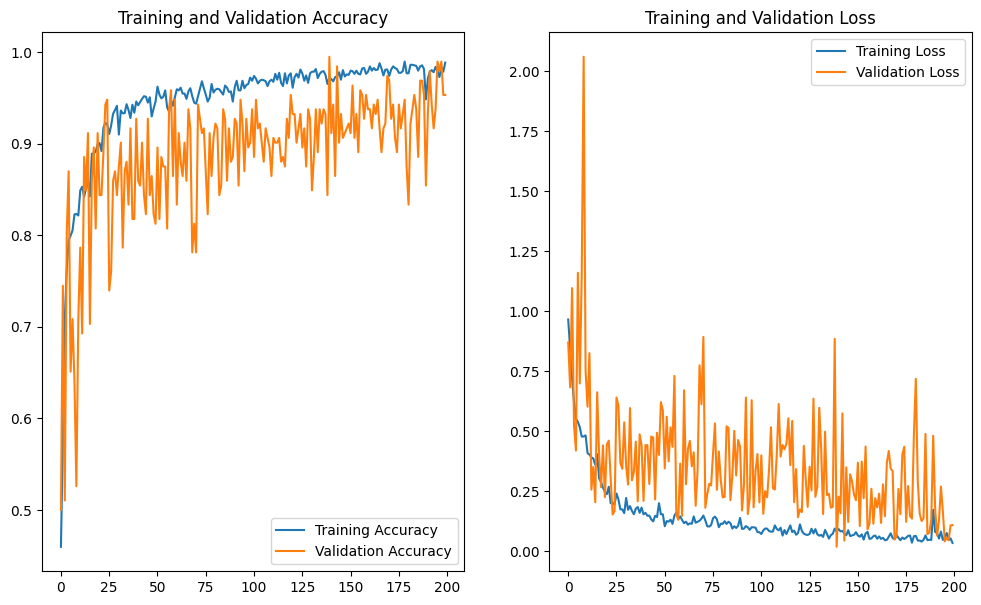

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
scores = model_48_DR4_001.evaluate(test_ds)

5/5 [==============================] - 5s 31ms/step - loss: 0.1540 - accuracy: 0.9625


In [ ]:
model_48_DR4_001.save('/content/drive/My Drive/best_model_48_DR4_001')

In [ ]:
# Model at Batch Size 48 and Learning Rate 0.01
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model_48_DR4_01 = Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')
])
model_48_DR4_01.build(input_shape = input_shape)
model_48_DR4_01.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (48, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (48, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (48, 127, 127, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (48, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (48, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (48, 60, 60, 64)         

In [ ]:
learning_rate = 0.01
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_48_DR4_01.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [ ]:
#Fit the model with training data and also pass validation data
history_48_DR4_01 = model_48_DR4_01.fit(
train_ds, epochs = 200, batch_size = Batch_Size, verbose = 1, validation_data = val_ds)

Epoch 1/200
36/36 [==============================] - 386s 1s/step - loss: 0.8776 - accuracy: 0.5267 - val_loss: 0.9991 - val_accuracy: 0.5573
Epoch 2/200
36/36 [==============================] - 39s 1s/step - loss: 0.7959 - accuracy: 0.6343 - val_loss: 0.8583 - val_accuracy: 0.5625
Epoch 3/200
36/36 [==============================] - 36s 987ms/step - loss: 0.7039 - accuracy: 0.7029 - val_loss: 0.7080 - val_accuracy: 0.6979
Epoch 4/200
36/36 [==============================] - 38s 1s/step - loss: 0.6326 - accuracy: 0.7459 - val_loss: 0.6556 - val_accuracy: 0.7292
Epoch 5/200
36/36 [==============================] - 38s 1s/step - loss: 0.5894 - accuracy: 0.7634 - val_loss: 0.6134 - val_accuracy: 0.7552
Epoch 6/200
36/36 [==============================] - 36s 1s/step - loss: 0.5977 - accuracy: 0.7500 - val_loss: 0.5704 - val_accuracy: 0.7865
Epoch 7/200
36/36 [==============================] - 40s 1s/step - loss: 0.5847 - accuracy: 0.7634 - val_loss: 0.7118 - val_accuracy: 0.6458
Epoch 8/2

In [ ]:
scores = model_48_DR4_01.evaluate(test_ds)

5/5 [==============================] - 5s 28ms/step - loss: 0.0723 - accuracy: 0.9708


In [ ]:
# Getting the model history to analyse
train_loss = history_48_DR4_01.history['loss']
train_acc = history_48_DR4_01.history['accuracy']

val_loss = history_48_DR4_01.history['val_loss']
val_acc = history_48_DR4_01.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

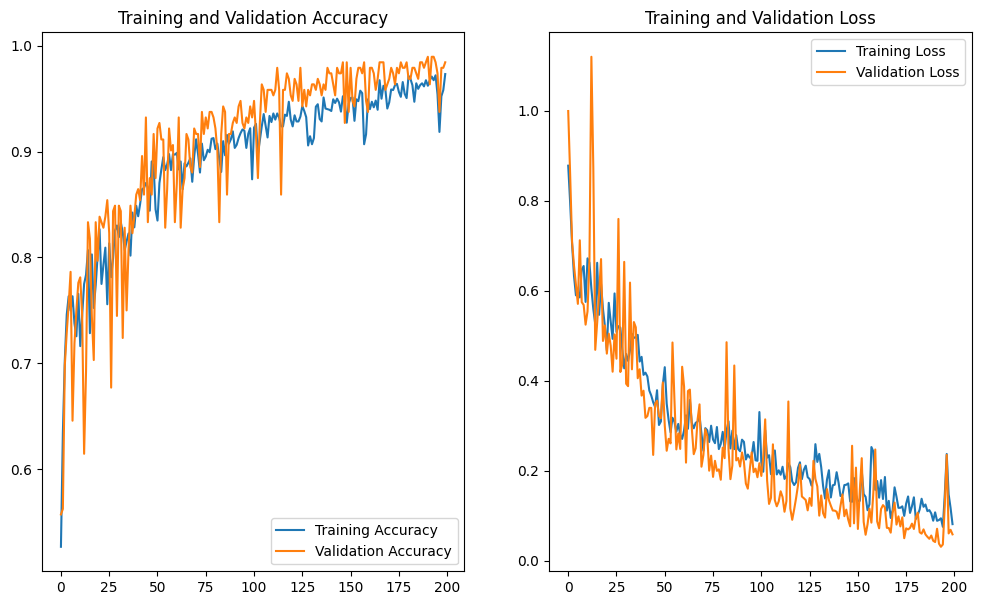

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
model_48_DR4_01.save('/content/drive/My Drive/best_model_48_DR4_01')

In [ ]:
# Model at Batch Size 48 and Learning Rate 0.0001
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model_48_DR4_0001 = Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')
])
model_48_DR4_0001.build(input_shape = input_shape)
model_48_DR4_0001.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (48, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (48, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (48, 127, 127, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (48, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (48, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (48, 60, 60, 64)         

In [ ]:
learning_rate = 0.0001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_48_DR4_0001.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [ ]:
#Fit the model with training data and also pass validation data
history_48_DR4_0001 = model_48_DR4_0001.fit(
train_ds, epochs = 200, batch_size = Batch_Size, verbose = 1, validation_data = val_ds)

Epoch 1/200
36/36 [==============================] - 848s 1s/step - loss: 1.0630 - accuracy: 0.4384 - val_loss: 1.0212 - val_accuracy: 0.4427
Epoch 2/200
36/36 [==============================] - 40s 1s/step - loss: 0.9694 - accuracy: 0.4669 - val_loss: 0.9413 - val_accuracy: 0.4635
Epoch 3/200
36/36 [==============================] - 41s 1s/step - loss: 0.9101 - accuracy: 0.4733 - val_loss: 0.9370 - val_accuracy: 0.4635
Epoch 4/200
36/36 [==============================] - 42s 1s/step - loss: 0.9026 - accuracy: 0.4651 - val_loss: 0.9322 - val_accuracy: 0.4635
Epoch 5/200
36/36 [==============================] - 41s 1s/step - loss: 0.8939 - accuracy: 0.4913 - val_loss: 0.9322 - val_accuracy: 0.4635
Epoch 6/200
36/36 [==============================] - 38s 1s/step - loss: 0.8940 - accuracy: 0.4942 - val_loss: 0.9189 - val_accuracy: 0.4635
Epoch 7/200
36/36 [==============================] - 39s 1s/step - loss: 0.8850 - accuracy: 0.5163 - val_loss: 0.9207 - val_accuracy: 0.4635
Epoch 8/200
